# Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import random
import hdbscan
import umap.umap_ as umap

from collections import Counter, defaultdict
from sklearn.metrics import silhouette_score, silhouette_samples, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader

## Load Previously extracted features

In [3]:
with open('/kaggle/input/50slide-features/50slides_features.pkl', 'rb') as f:
    slide_features = pickle.load(f)

### 50 images total, 10 per class

Counter({'CC': 10, 'EC': 10, 'HGSC': 10, 'LGSC': 10, 'MC': 10})


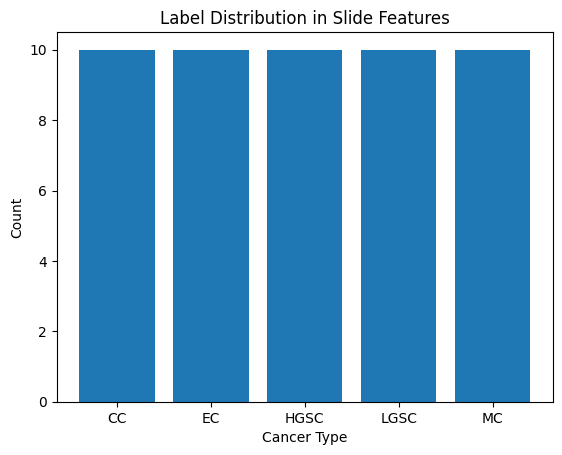

In [4]:
# Extract labels
labels = [data['label'] for data in slide_features.values()]

# Count label occurrences
label_counts = Counter(labels)

# Print label distribution
print(label_counts)

# Optionally, visualize the distribution
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Cancer Type')
plt.ylabel('Count')
plt.title('Label Distribution in Slide Features')
plt.show()

## Train-VAL-Test Split

In [5]:
# Convert slide_features to a suitable format
data = [(features['features'], features['label']) for path, features in slide_features.items()]

# Organize data by labels
data_by_label = defaultdict(list)
for features, label in data:
    data_by_label[label].append((features, label))

# Split data for each label into train, validation, and test
train_data = []
val_data = []
test_data = []

for label, label_data in data_by_label.items():
    # Split data for this label into train and test
    train_val_label_data, test_label_data = train_test_split(label_data, test_size=0.2)
    
    # Split train data into train and validation
    train_label_data, val_label_data = train_test_split(train_val_label_data, test_size=0.25)  # 0.25 x 0.8 = 0.2 of original
    
    # Append split data to respective sets
    train_data.extend(train_label_data)
    val_data.extend(val_label_data)
    test_data.extend(test_label_data)

# Shuffle the datasets
random.shuffle(train_data)
random.shuffle(val_data)
random.shuffle(test_data)

# Function to check balance in each set
def check_balance(dataset):
    label_counts = defaultdict(int)
    for _, label in dataset:
        label_counts[label] += 1
    return dict(label_counts)

# Display balance of each set
print("Train balance:", check_balance(train_data))
print("Validation balance:", check_balance(val_data))
print("Test balance:", check_balance(test_data))

Train balance: {'LGSC': 6, 'MC': 6, 'CC': 6, 'EC': 6, 'HGSC': 6}
Validation balance: {'HGSC': 2, 'MC': 2, 'LGSC': 2, 'EC': 2, 'CC': 2}
Test balance: {'CC': 2, 'HGSC': 2, 'MC': 2, 'LGSC': 2, 'EC': 2}


## Visualize Feature Vectors' Clusters for Training Data

In [6]:
train_features = []
train_labels = []

# Iterate over the training data to aggregate features and labels
for bag, label in train_data:
    for feature_vector in bag:
        train_features.append(feature_vector)
        train_labels.append(label)

# Convert to NumPy arrays
train_features = np.array(train_features)
train_labels = np.array(train_labels)

In [25]:
# UMAP on training data features
umap_reducer = umap.UMAP(n_neighbors=30, n_components=10, min_dist=0.01, metric='euclidean')
umap_embedding_train = umap_reducer.fit_transform(train_features)

In [29]:
# Adjust HDBSCAN parameters
min_cluster_size = 50  # Increase for larger minimum cluster size
min_samples = 50  # Increase to reduce noise
epsilon = 0.35 # Adjust based on distance threshold

# Clustering with HDBSCAN
cluster_labels_train = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_epsilon=epsilon,
                                        gen_min_span_tree=True).fit_predict(umap_embedding_train)

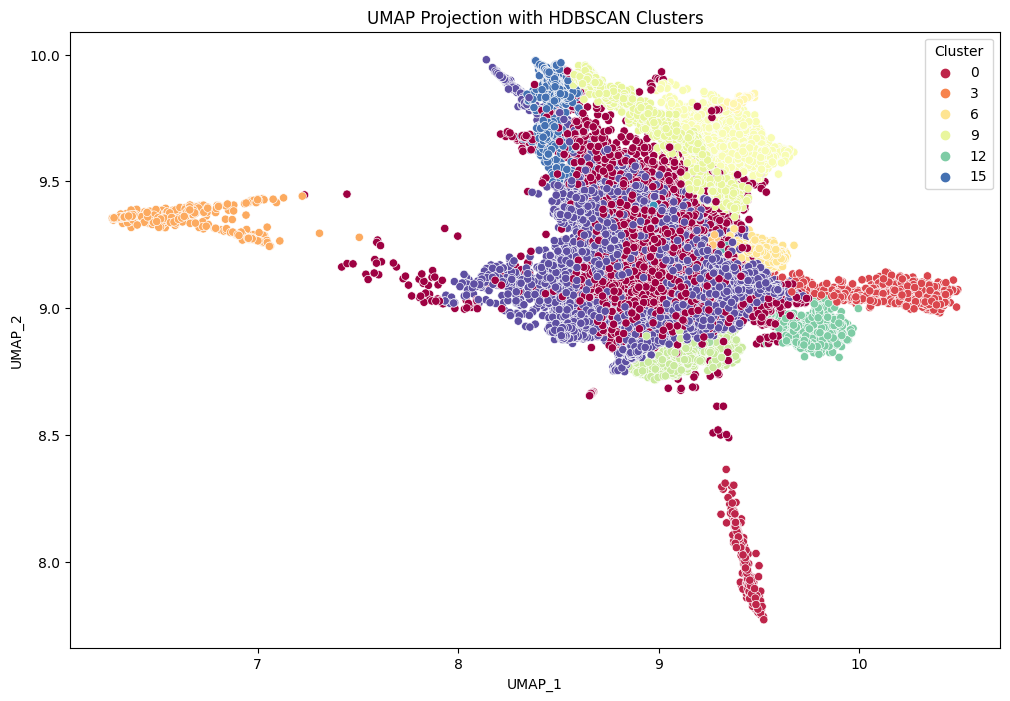

In [30]:
# Convert the UMAP embedding and cluster labels to a pandas DataFrame for plotting
columns = [f'UMAP_{i+1}' for i in range(umap_embedding_train.shape[1])]
embedding_df_train = pd.DataFrame(umap_embedding_train, columns=columns)
embedding_df_train['Cluster'] = cluster_labels_train

# Plot using Seaborn's scatterplot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=embedding_df_train, x='UMAP_1', y='UMAP_2', hue='Cluster', palette='Spectral')
plt.title("UMAP Projection with HDBSCAN Clusters")
plt.show()

In [41]:
# Overall silhouette score
overall_silhouette_score = silhouette_score(umap_embedding_train, cluster_labels_train)
print("Overall Silhouette Score: ", overall_silhouette_score)

# Silhouette scores for each cluster
silhouette_vals = silhouette_samples(umap_embedding_train, cluster_labels_train)
cluster_avg_silhouette = pd.DataFrame({'Silhouette': silhouette_vals, 'Cluster': cluster_labels_train}).groupby('Cluster')['Silhouette'].mean()
for cluster, score in cluster_avg_silhouette.items():
    print(f"Cluster {cluster} average silhouette score: {score:.4f}")

Overall Silhouette Score:  0.08098319
Cluster -1 average silhouette score: -0.3115
Cluster 0 average silhouette score: 0.8933
Cluster 1 average silhouette score: 0.6817
Cluster 2 average silhouette score: 0.9637
Cluster 3 average silhouette score: 0.7036
Cluster 4 average silhouette score: 0.8664
Cluster 5 average silhouette score: 0.7534
Cluster 6 average silhouette score: 0.7683
Cluster 7 average silhouette score: 0.8980
Cluster 8 average silhouette score: 0.4735
Cluster 9 average silhouette score: 0.2257
Cluster 10 average silhouette score: 0.3555
Cluster 11 average silhouette score: 0.7214
Cluster 12 average silhouette score: 0.4819
Cluster 13 average silhouette score: 0.6357
Cluster 14 average silhouette score: 0.7453
Cluster 15 average silhouette score: 0.4911
Cluster 16 average silhouette score: -0.2503


<Axes: >

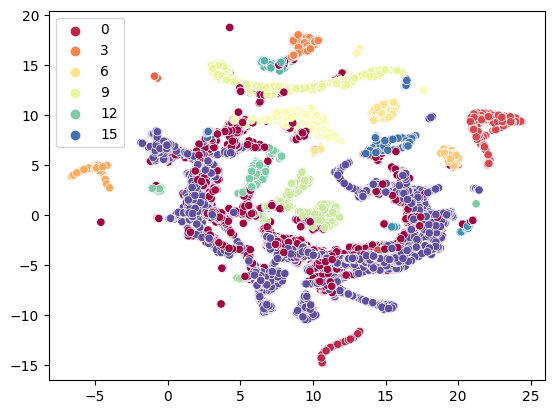

In [31]:
# Further reduction for visualization
umap_reducer_vis = umap.UMAP(n_components=2)
umap_vis = umap_reducer_vis.fit_transform(umap_embedding_train)

# Plotting
sns.scatterplot(x=umap_vis[:, 0], y=umap_vis[:, 1], hue=cluster_labels_train, palette='Spectral')

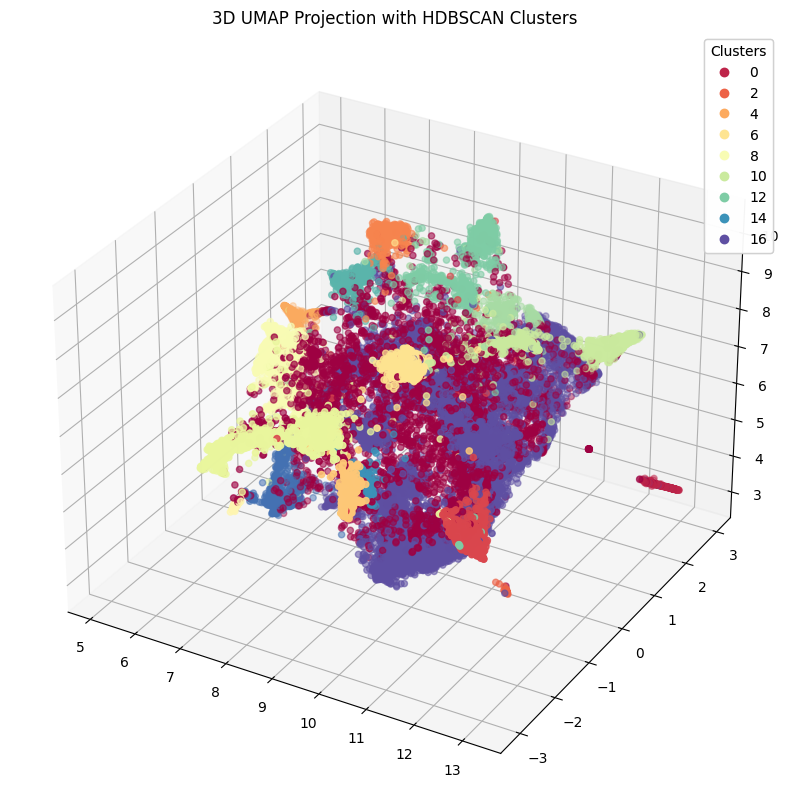

In [32]:
# from mpl_toolkits.mplot3d import Axes3D

# Create a UMAP instance for 3D projection
umap_3d = umap.UMAP(n_neighbors=30, n_components=3, min_dist=0.01, metric='cosine')
umap_embedding_3d = umap_3d.fit_transform(train_features)

# Plotting
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(umap_embedding_3d[:, 0], umap_embedding_3d[:, 1], umap_embedding_3d[:, 2], c=cluster_labels_train, cmap='Spectral')
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)
plt.title("3D UMAP Projection with HDBSCAN Clusters")
plt.show()

Cluster -1 label distribution:
Original_Label
CC      1374
MC       814
LGSC     793
HGSC     684
EC       670
Name: count, dtype: int64



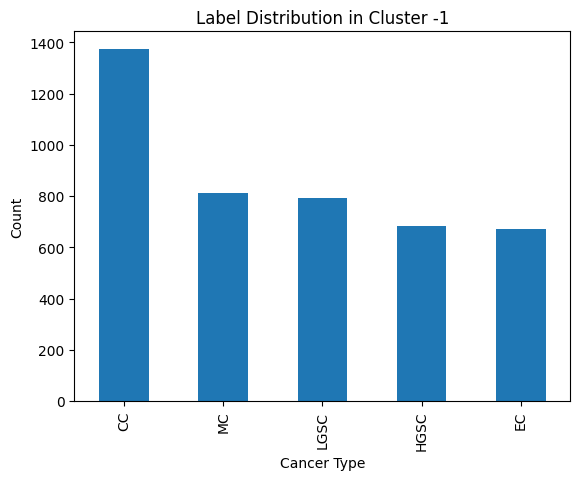

Cluster 0 label distribution:
Original_Label
HGSC    325
Name: count, dtype: int64



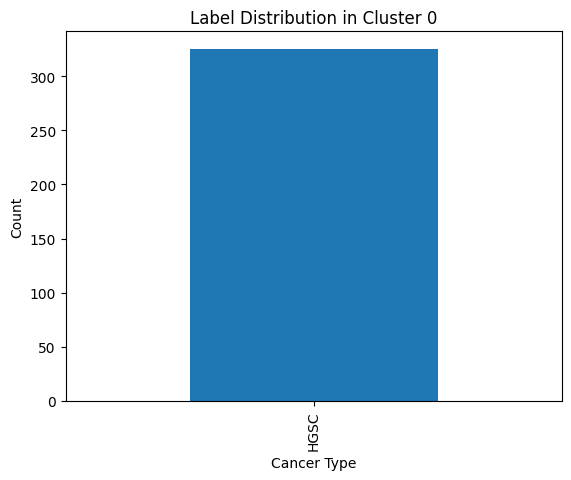

Cluster 1 label distribution:
Original_Label
MC      1182
CC        16
HGSC      13
LGSC       9
EC         3
Name: count, dtype: int64



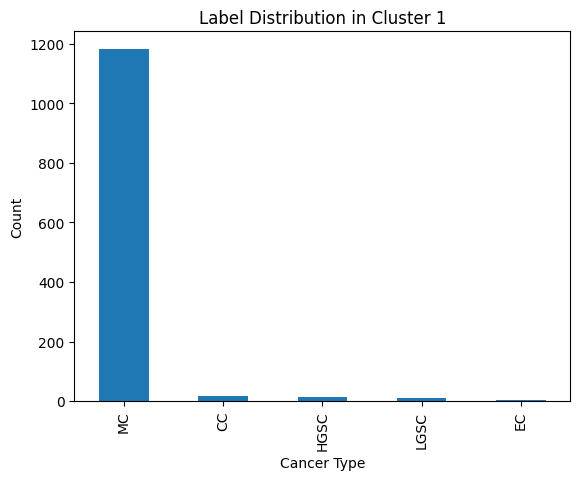

Cluster 2 label distribution:
Original_Label
LGSC    52
Name: count, dtype: int64



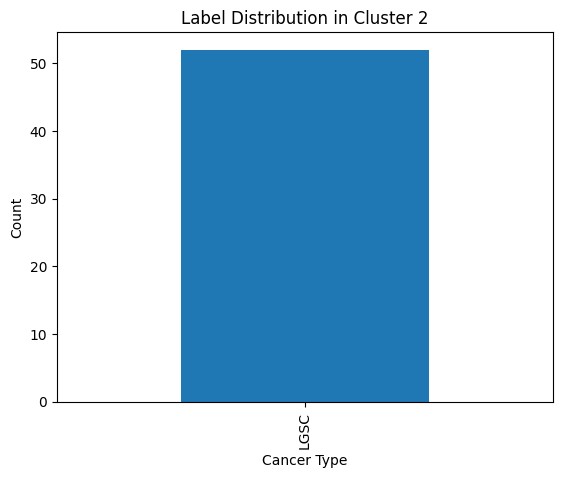

Cluster 3 label distribution:
Original_Label
LGSC    585
CC        7
EC        2
HGSC      1
MC        1
Name: count, dtype: int64



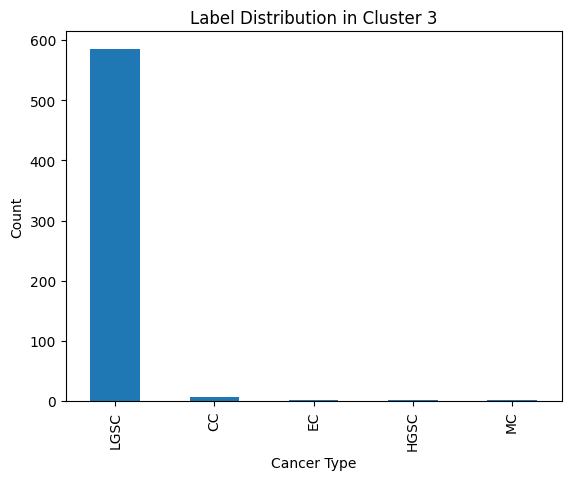

Cluster 4 label distribution:
Original_Label
HGSC    362
EC        2
Name: count, dtype: int64



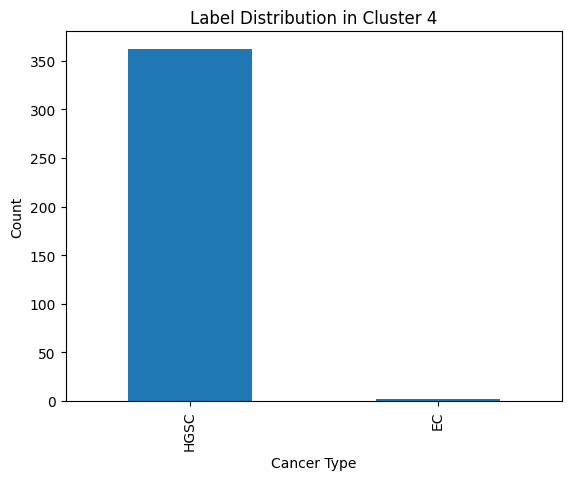

Cluster 5 label distribution:
Original_Label
EC    395
MC      2
Name: count, dtype: int64



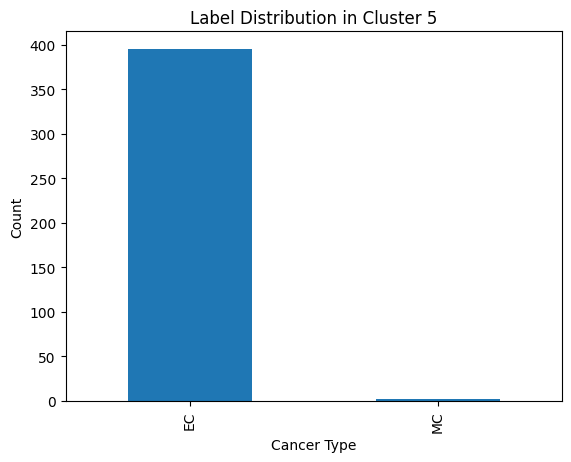

Cluster 6 label distribution:
Original_Label
CC      727
MC        7
EC        4
LGSC      3
HGSC      1
Name: count, dtype: int64



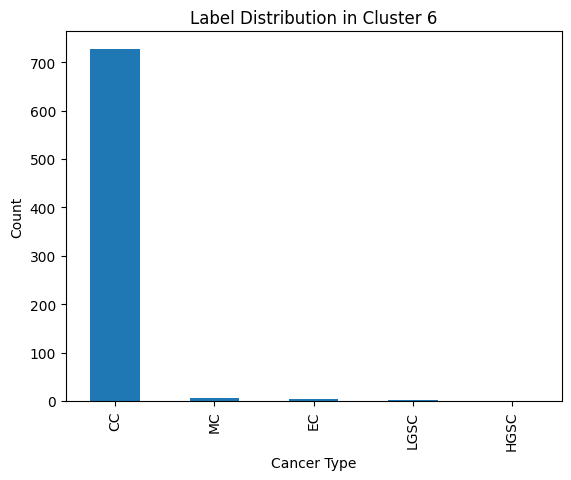

Cluster 7 label distribution:
Original_Label
MC    97
CC     1
Name: count, dtype: int64



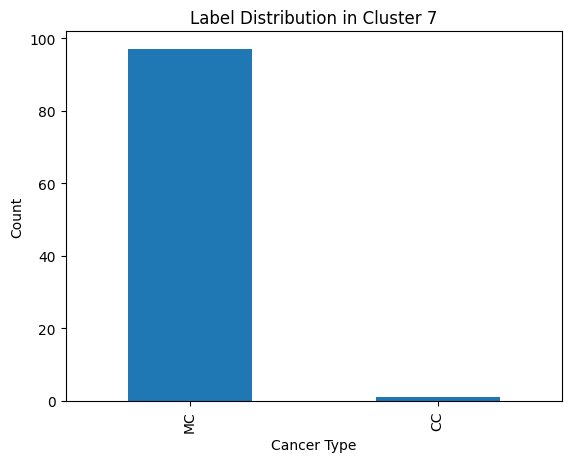

Cluster 8 label distribution:
Original_Label
CC      1279
MC       157
LGSC      94
HGSC      15
EC         6
Name: count, dtype: int64



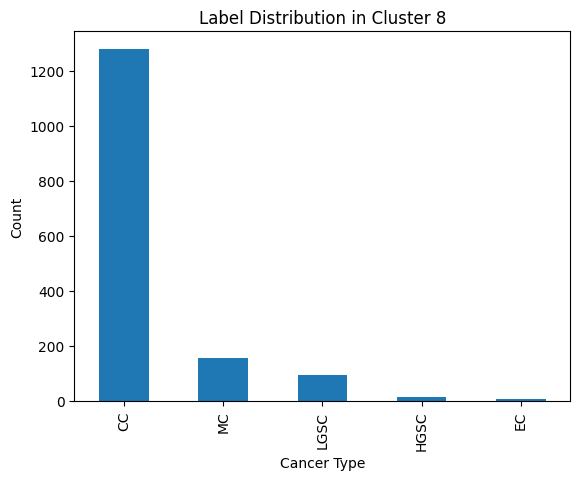

Cluster 9 label distribution:
Original_Label
MC      1864
EC        32
CC        31
HGSC      11
LGSC       4
Name: count, dtype: int64



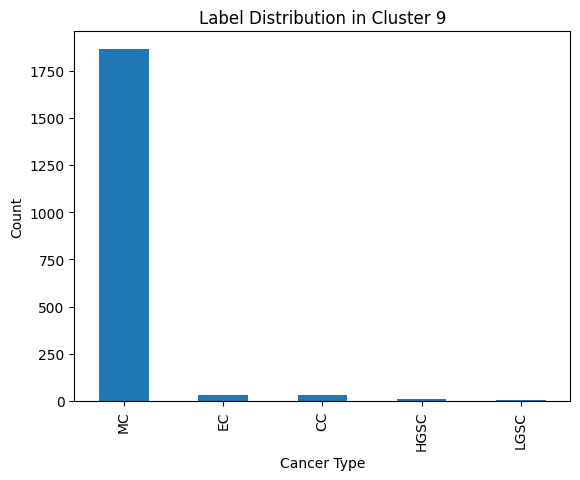

Cluster 10 label distribution:
Original_Label
EC      915
MC      657
LGSC     33
CC       15
HGSC     12
Name: count, dtype: int64



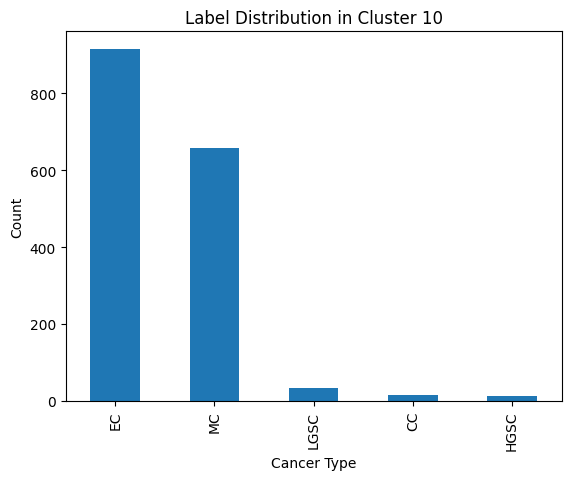

Cluster 11 label distribution:
Original_Label
LGSC    277
HGSC      8
CC        4
EC        2
MC        1
Name: count, dtype: int64



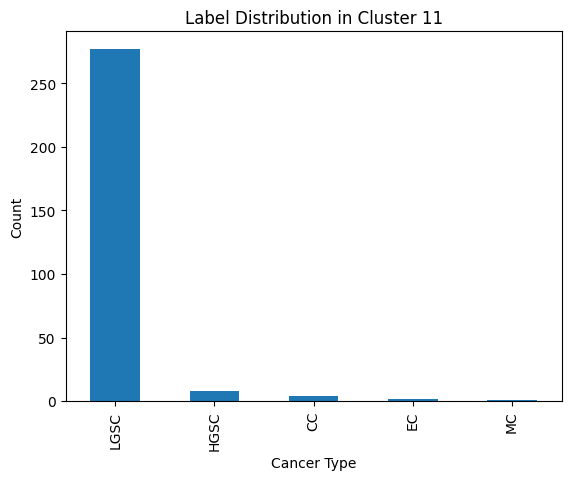

Cluster 12 label distribution:
Original_Label
CC      636
LGSC    458
EC        5
HGSC      5
MC        2
Name: count, dtype: int64



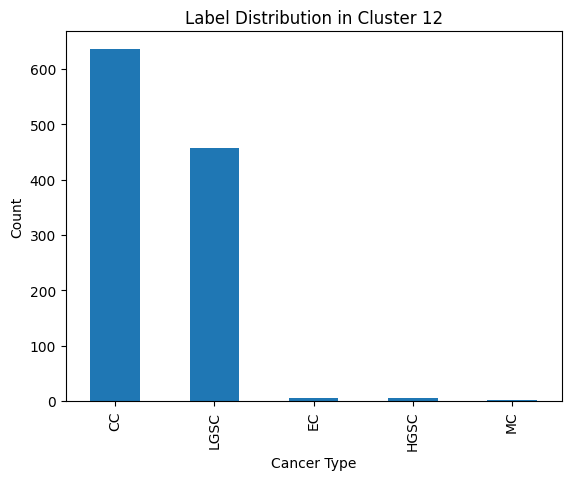

Cluster 13 label distribution:
Original_Label
LGSC    439
CC        6
MC        5
HGSC      3
EC        2
Name: count, dtype: int64



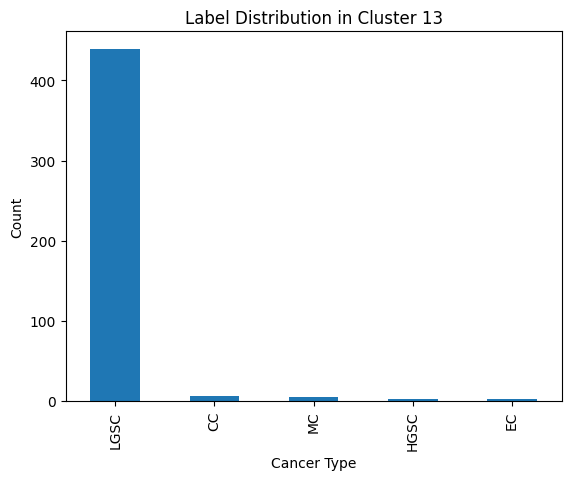

Cluster 14 label distribution:
Original_Label
EC      215
LGSC      2
CC        2
MC        2
Name: count, dtype: int64



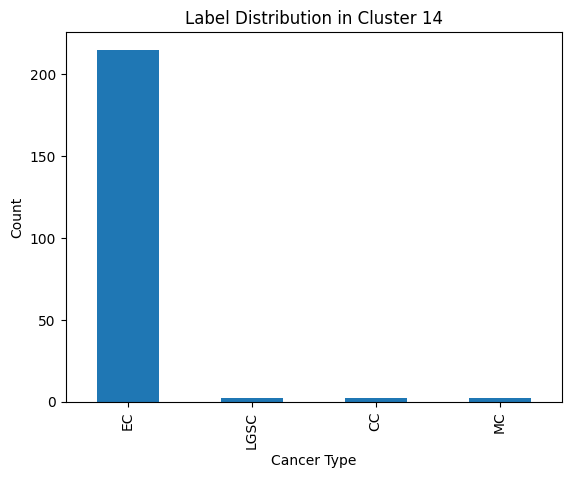

Cluster 15 label distribution:
Original_Label
CC      688
MC       96
EC       65
HGSC     42
LGSC     13
Name: count, dtype: int64



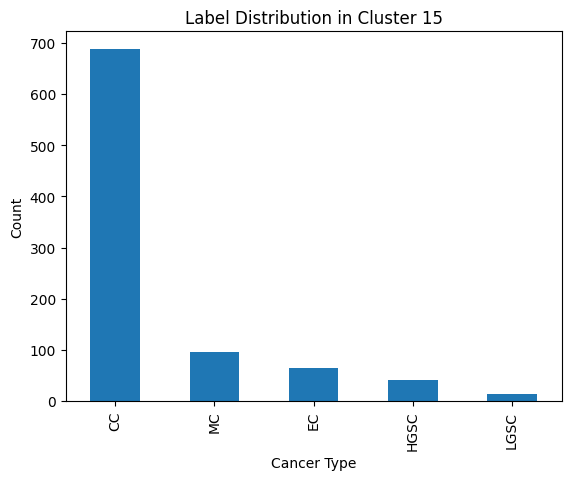

Cluster 16 label distribution:
Original_Label
CC      3352
HGSC    3193
EC      2102
MC      1456
LGSC     751
Name: count, dtype: int64



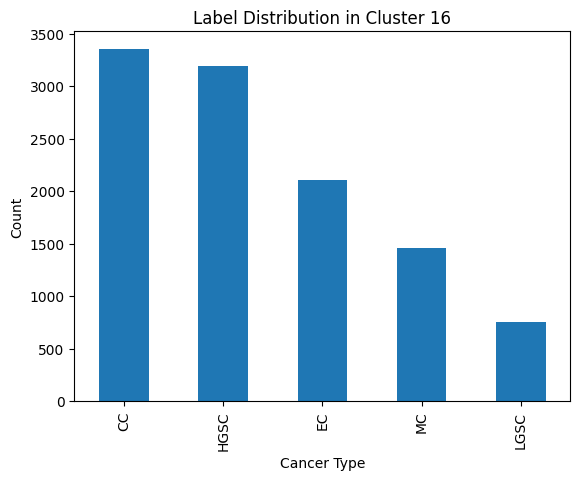

In [34]:
# Create a DataFrame with UMAP embeddings, HDBSCAN cluster labels, and original labels
embedding_df_train['Original_Label'] = train_labels

# Analyze the labels for each cluster
for cluster in range(-1, 17):  
    cluster_data_train = embedding_df_train[embedding_df_train['Cluster'] == cluster]
    label_counts = cluster_data_train['Original_Label'].value_counts()
    print(f"Cluster {cluster} label distribution:\n{label_counts}\n")

    # Optionally, create a bar plot for each cluster's label distribution
    label_counts.plot(kind='bar')
    plt.title(f"Label Distribution in Cluster {cluster}")
    plt.xlabel("Cancer Type")
    plt.ylabel("Count")
    plt.show()

## Multiple Instance Learning (MIL) classifier

### Data Preparation

In [35]:
num_representatives = 10  # Number of representatives to select from each cluster
representative_features = defaultdict(list)

# Clusters to exclude
excluded_clusters = [-1, 10, 12, 16]

# Iterating through unique clusters
for cluster in np.unique(cluster_labels_train):
    if cluster not in excluded_clusters:
        cluster_indices = np.where(cluster_labels_train == cluster)[0]
        selected_indices = np.random.choice(cluster_indices, num_representatives, replace=False)
        for idx in selected_indices:
            representative_features[cluster].append(train_features[idx])

# representative_features now holds the selected feature vectors for each cluster

In [36]:
augmented_train_data = []

for bag_features, label in train_data:
    augmented_bag = bag_features.copy()

    # Add representatives from each cluster to the bag
    for cluster_reps in representative_features.values():
        augmented_bag.extend(cluster_reps)
    
    augmented_train_data.append((augmented_bag, label))

In [48]:
# Set thresholds for exclusion
silhouette_threshold = 0.6  # Threshold for silhouette score
homogeneity_max = 1  # Threshold max class dominance in cluster
homogeneity_min = 0.7 # Threshold min class dominance in cluster
minimum_cluster_size = 60  # Minimum number of samples in a cluster

excluded_clusters = []

# Analyze each cluster to decide on exclusion
for cluster in np.unique(cluster_labels_train):
    cluster_indices = np.where(cluster_labels_train == cluster)[0]
    cluster_silhouette_score = cluster_avg_silhouette[cluster]

    # Calculate label homogeneity
    label_counts = defaultdict(int)
    for idx in cluster_indices:
        label_counts[train_labels[idx]] += 1
    max_label_proportion = max(label_counts.values()) / sum(label_counts.values())

    # Check conditions for exclusion
    if (cluster_silhouette_score < silhouette_threshold or
        max_label_proportion > homogeneity_max or
        max_label_proportion < homogeneity_min or
        len(cluster_indices) < minimum_cluster_size):
        excluded_clusters.append(cluster)

print("Excluded Clusters:", excluded_clusters)

Excluded Clusters: [-1, 2, 8, 9, 10, 12, 15, 16]


In [49]:
# Set the base number of representatives per cluster
base_representatives = 12

representative_features = defaultdict(list)

# Function to calculate proportional representatives
def calculate_proportional_representatives(class_distribution, total_representatives):
    total_count = sum(class_distribution.values())
    proportional_representatives = {}
    for class_label, count in class_distribution.items():
        proportional_count = int((count / total_count) * total_representatives)
        proportional_representatives[class_label] = proportional_count
    return proportional_representatives

# Iterate through each cluster
for cluster in np.unique(cluster_labels_train):
    if cluster not in excluded_clusters:
        cluster_indices = np.where(cluster_labels_train == cluster)[0]
        print("")
        # Get class distribution in actual counts
        class_distribution = defaultdict(int)
        for idx in cluster_indices:
            class_distribution[train_labels[idx]] += 1

        # Adjust the number of representatives based on cluster silhouette score
        silhouette_score = cluster_avg_silhouette[cluster]
        adjusted_representatives = int(base_representatives * max(0.5, silhouette_score))

        # Calculate proportional representatives
        proportional_representatives = calculate_proportional_representatives(class_distribution, adjusted_representatives)

        # Print class distribution and number of representatives
        print(f"Cluster {cluster}: Class Distribution - {dict(class_distribution)}")
        print(f"  Proportional Representatives: {proportional_representatives}")

        # Select and add representatives
        for class_label, num_reps in proportional_representatives.items():
            class_indices = [i for i in cluster_indices if train_labels[i] == class_label]
            selected_indices = np.random.choice(class_indices, num_reps, replace=True)

            for idx in selected_indices:
                representative_features[cluster].append(train_features[idx])

            # Print the number of representatives added for each class
            print(f"  Adding {num_reps} for class {class_label}")

# representative_features now contains the selected feature vectors for each cluster


Cluster 0: Class Distribution - {'HGSC': 325}
  Proportional Representatives: {'HGSC': 10}
  Adding 10 for class HGSC

Cluster 1: Class Distribution - {'LGSC': 9, 'MC': 1182, 'CC': 16, 'EC': 3, 'HGSC': 13}
  Proportional Representatives: {'LGSC': 0, 'MC': 7, 'CC': 0, 'EC': 0, 'HGSC': 0}
  Adding 0 for class LGSC
  Adding 7 for class MC
  Adding 0 for class CC
  Adding 0 for class EC
  Adding 0 for class HGSC

Cluster 3: Class Distribution - {'LGSC': 585, 'CC': 7, 'HGSC': 1, 'MC': 1, 'EC': 2}
  Proportional Representatives: {'LGSC': 7, 'CC': 0, 'HGSC': 0, 'MC': 0, 'EC': 0}
  Adding 7 for class LGSC
  Adding 0 for class CC
  Adding 0 for class HGSC
  Adding 0 for class MC
  Adding 0 for class EC

Cluster 4: Class Distribution - {'HGSC': 362, 'EC': 2}
  Proportional Representatives: {'HGSC': 9, 'EC': 0}
  Adding 9 for class HGSC
  Adding 0 for class EC

Cluster 5: Class Distribution - {'EC': 395, 'MC': 2}
  Proportional Representatives: {'EC': 8, 'MC': 0}
  Adding 8 for class EC
  Adding

In [50]:
# Augmenting the training data with representatives
augmented_train_data = []

for bag_features, label in train_data:
    augmented_bag = bag_features.copy()

    # Add representatives from each cluster to the bag
    for cluster_reps in representative_features.values():
        augmented_bag.extend(cluster_reps)

    augmented_train_data.append((augmented_bag, label))

# Optional: Print out the distribution of the number of representatives per cluster
for cluster, reps in representative_features.items():
    print(f"Cluster {cluster}: {len(reps)} representatives added")

Cluster 0: 10 representatives added
Cluster 1: 7 representatives added
Cluster 3: 7 representatives added
Cluster 4: 9 representatives added
Cluster 5: 8 representatives added
Cluster 6: 8 representatives added
Cluster 7: 9 representatives added
Cluster 11: 7 representatives added
Cluster 13: 6 representatives added
Cluster 14: 7 representatives added


In [51]:
# Create a mapping from label strings to integers
unique_labels = sorted(set(label for _, label in data))
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}

class MILDataset(Dataset):
    def __init__(self, data, label_to_idx):
        self.data = data
        self.label_to_idx = label_to_idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        feature_vectors, label = self.data[idx]
        label_idx = self.label_to_idx[label]  # Convert label to integer
        return torch.tensor(feature_vectors), torch.tensor(label_idx, dtype=torch.float32)

# Creating the datasets with augmented training data
train_dataset = MILDataset(augmented_train_data, label_to_idx)
val_dataset = MILDataset(val_data, label_to_idx)
test_dataset = MILDataset(test_data, label_to_idx)

# DataLoaders remain the same
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### Train and Test MIL Model:

In [75]:
class AttentionMIL(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout_rate=0.5):
        super(AttentionMIL, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim) # Batch normalization
        self.dropout1 = nn.Dropout(dropout_rate)
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Softmax(dim=0)
        )
        self.classifier = nn.Linear(hidden_dim, num_classes)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, bag):
        h = self.fc1(bag)  # Apply linear layer
        # h = self.bn1(h)    # Apply batch normalization
        h = torch.relu(h)  # Apply ReLU activation
        h = self.dropout1(h)
        a = self.attention(h)
        v = torch.sum(a * h, dim=0)
        v = self.dropout2(v)
        y = self.classifier(v)
        return y, a

# Number of unique classes
num_classes = len(unique_labels)

model = AttentionMIL(input_dim=2048, hidden_dim=256, num_classes=num_classes)
loss_function = nn.CrossEntropyLoss()  # CrossEntropyLoss for multiclass
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Early Stopping Parameters
best_val_loss = float('inf')
patience = 5
patience_counter = 0

# Model Training with Validation
num_epochs = 9
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    # Training loop
    for bags, labels in train_loader:
        optimizer.zero_grad()
        bags = bags.squeeze(0)  # Remove the extra dimension from bags
        labels = labels.squeeze(0).long()  # Remove extra dimension and ensure long type for labels
        output, _ = model(bags)
        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(output.data, 0)
        train_total += 1
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_loss /= len(train_loader)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for bags, labels in val_loader:
            bags = bags.squeeze(0)
            labels = labels.squeeze(0).long()
            output, _ = model(bags)
            loss = loss_function(output, labels)
            val_loss += loss.item()
            _, predicted = torch.max(output.data, 0)
            val_total += 1
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_loss /= len(val_loader)
    
    # Step the scheduler
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Stopping early due to no improvement in validation loss.")
        break

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

Epoch 1/9, Train Loss: 1.7990, Train Acc: 10.00%, Validation Loss: 1.6183, Val Acc: 20.00%
Epoch 2/9, Train Loss: 1.6621, Train Acc: 23.33%, Validation Loss: 1.5931, Val Acc: 30.00%
Epoch 3/9, Train Loss: 1.5959, Train Acc: 26.67%, Validation Loss: 1.5825, Val Acc: 30.00%
Epoch 4/9, Train Loss: 1.6353, Train Acc: 13.33%, Validation Loss: 1.5715, Val Acc: 30.00%
Epoch 5/9, Train Loss: 1.5797, Train Acc: 30.00%, Validation Loss: 1.5601, Val Acc: 30.00%
Epoch 6/9, Train Loss: 1.6001, Train Acc: 26.67%, Validation Loss: 1.5450, Val Acc: 50.00%
Epoch 7/9, Train Loss: 1.5225, Train Acc: 40.00%, Validation Loss: 1.5367, Val Acc: 20.00%
Epoch 8/9, Train Loss: 1.5244, Train Acc: 23.33%, Validation Loss: 1.5184, Val Acc: 40.00%
Epoch 9/9, Train Loss: 1.3981, Train Acc: 43.33%, Validation Loss: 1.4898, Val Acc: 40.00%


In [76]:
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for bags, labels in test_loader:
        output, _ = model(bags.squeeze(0))
        _, predicted_labels = torch.max(output, 0)  # Get the index of the max log-probability
        predictions.append(predicted_labels.item())  # Append scalar value
        true_labels.append(labels.squeeze(0).item())  # Append scalar value

# Convert lists to arrays for metric calculation
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='macro', zero_division=1)
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.5000
Precision: 0.6133
Recall: 0.5000
F1 Score: 0.4076


In [78]:
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

# Use idx_to_label to map numeric predictions back to label names
predicted_labels = [idx_to_label[int(idx)] for idx in predictions]
true_label_names = [idx_to_label[int(idx)] for idx in true_labels]

# Now predicted_labels and true_label_names contain the label names
print(predicted_labels)
print(true_label_names)

['LGSC', 'EC', 'EC', 'EC', 'LGSC', 'CC', 'HGSC', 'EC', 'LGSC', 'EC']
['CC', 'CC', 'HGSC', 'MC', 'LGSC', 'MC', 'HGSC', 'EC', 'LGSC', 'EC']
